# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
1. use command-line script to get prediction dataset
2. shifting code to, working with full data on remote PC
3. CRPS averaging. sanity checks.  re-writing rank histogram.
4. creating function to compare different models on CRPS, Spread-skill, RankHistogram. should be simple.

Questions:
- i added mean, std data in data/WeatherBench/5.625deg/ directory. It's the one that you initially uploaded in test.zip for the starter exercise (12-probabilistic dropout). Is this for 1979-2014? And should we use the same for test data since it won't be much different?

-I am having trouble running DataGenerator() function in PC. It complains of MemoryError, even if I turn on GPU. The kernel also gets interrupted and has to restart. Any idea what should be done?

In [1]:
%load_ext autoreload
%autoreload 2

In [192]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
!conda install tensorflow=2.1

Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - tensorflow=2.1

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [4]:
# You only need this if you are using a GPU
#os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

In [5]:
datadir = '/Users/sagar/Library/Mobile\ Documents/com~apple~CloudDocs/studies/WeatherBench/Testing_WeatherBench/5.625deg/'# Change this to where you downloaded the data

In [6]:
!ls $datadir

13-mean.nc                     geopotential
13-resnet_bn_dr_0.1.h5         temperature
13-resnet_bn_dr_0.1_weights.h5 u_component_of_wind
13-std.nc                      v_component_of_wind
constants


In [7]:
exp_id = '13-resnet_bn_dr_0.1'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 
            'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 
            'constants': ['lsm','orography','lat2d']}  

output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72 #prediction of forecast is at 72 hours after input time.
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = 1
dropout = 0.1  # This is the important one

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [8]:
#ds = xr.merge([xr.open_mfdataset('../test/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]) 
df1=xr.open_mfdataset('../5.625deg/geopotential/*.nc', combine='by_coords') 
df2=xr.open_mfdataset('../5.625deg/temperature/*.nc', combine='by_coords') 
df3=xr.open_mfdataset('../5.625deg/u_component_of_wind/*.nc', combine='by_coords') 
df4=xr.open_mfdataset('../5.625deg/v_component_of_wind/*.nc', combine='by_coords')  
df5=xr.open_mfdataset('../5.625deg/constants/*.nc', combine='by_coords')  
ds=xr.merge([df1,df2,df3,df4,df5])

In [9]:
mean = xr.open_dataarray('../5.625deg/13-mean.nc') #for just our subsampled data. 15 levels ('the constants are at level=1)':z200,z500,z850,t200 and so on.
std = xr.open_dataarray('../5.625deg/13-std.nc')

In [10]:
dg_test = DataGenerator(
    ds, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
    shuffle=False, output_vars=output_vars
)

DG start 08:53:20.948147
DG normalize 08:53:21.001660
DG load 08:53:21.013926
Loading data into RAM
DG done 08:53:46.175021


In [86]:
# You can index into the data generator to obain a feature/target pair
# [batch, x, y, channel]
X,y=dg_test[0]
X.shape, y.shape

((32, 32, 64, 15), (32, 32, 64, 2))

In [11]:
#ds

In [12]:
#ToDo: #Get full data in X,Y instead of just 1 batch
# for (X,y) in dg_test
#      X,y=dg_test(i)
#       append

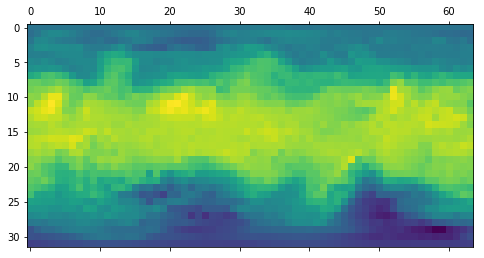

In [87]:
plt.matshow(y[0, :, :, 1]) #y[...,0] is z500 and y[...,1] is t850. normalized. 
#y is the observation after lead_time (=72) hours from input X. The ground truth.

# Load the model
Now let's load the pretrained model. Check the build resnet option .

In [88]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_test.data.lat), len(dg_test.data.lon), len(dg_test.data.level) * nt_in),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout)

In [89]:
model.compile('adam', 'mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d_16 (PeriodicCon (None, 32, 64, 128)  94208       input_2[0][0]                    
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 32, 64, 128)  0           periodic_conv2d_16[0][0]         
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 32, 64, 128)  512         activation_15[0][0]              
____________________________________________________________________________________________

In [90]:
model.load_weights('../5.625deg/13-resnet_bn_dr_0.1_weights.h5')

## Create a deterministic prediction

The model has been trained to create a deterministic prediction. For this dropout is turned off during test time. Let's create a prediction for the first sample. Thanks to Tensorflow 2 we can tread the model as a function just like in PyTorch.

In [197]:
#pred_deterministic = model(X[:1]).numpy().squeeze(); pred_deterministic.shape; #to add tf.enable_eager_execution() in src/networks.py line6. have to remove if you want to run ensemble prediction :(.

In [ ]:
# Look at the predictions
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# ax1.matshow(pred[..., 0]) #z500 normalized
# ax2.matshow(pred[..., 1]) #t850 normalized

# Create an ensemble using test-time dropout
Now it's your turn. The pretrained model contains several dropout layers which are only active during training. Your job is to turn dropout on during inference as well. This should result in a model that creates a slightly different prediction every time. Hint: Google "Keras test-time dropout".

In [91]:
##weirdly this function works when tf.enable_eager_execution() is disabled.
#but 'pred' for single determinstic works when tf.enable_eager_execution() is enabled. 
#issue with tensorflow version. couldn't solve right now.

#keras switches off test time dropout by default. we could either switch it on permanently.. by putting somewhere an argument training=true). this will put both training and testing to use dropout
#but since we have a pre trained model, better just to activate dropout in testing rather than training again. beware: we also activate bacthnorm or any other that was inactive in test phase by default.
#https://stackoverflow.com/questions/52756283/adding-dropout-to-testing-inference-phase
from tensorflow.keras import backend as K
func = K.function(model.inputs + [K.learning_phase()], model.outputs)

In [92]:
# to use dropout in testing phase, pass 1 to set the learning phase to training mode
outputs = func([X[:1]] + [1.]) #for a single sample. #gives a new prediction each time.
pred2 = np.asarray(outputs, dtype=np.float32).squeeze(); print(pred2.shape) #reshape
#outputs

(32, 64, 2)


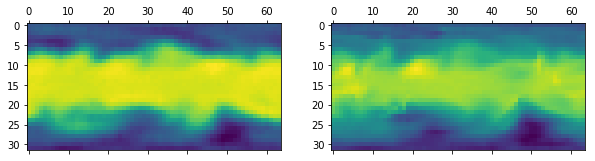

In [93]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred2[..., 0]) #z500 normalized
ax2.matshow(pred2[..., 1]) #t850 normalized

# Creating Ensemble Forecasts

In [94]:
number_of_forecasts=100
time=10 ## keep it lower for testing code. takes time.
#number of inputs. different input times each for which an ensemble of predictions is made. 
obs=y[:time,...] #ground truth
pred_ensemble = np.array([np.asarray(func([X[:time]] + [1.]), dtype=np.float32).squeeze() for _ in range(number_of_forecasts)])

In [98]:
print(pred_ensemble.shape) #(forecast, time, lat, lon, variable)
obs=y[:time,...] #ground truth
print(obs.shape) 

(100, 10, 32, 64, 2)
(10, 32, 64, 2)


In [100]:
pred_ensemble_reserve=pred_ensemble #just for testing code.
obs_reserve=obs

In [101]:
#ToDo: If we unnormalize now, as numpy arrays, then it works fine. 
#If we unnormalize after turning them into xarrays, there is a problem, 
#since ds_test.mean and ds_test.std dont have proper names for z500, t850? Will solve.
pred_ensemble=(pred_ensemble * dg_test.std.isel(level=dg_test.output_idxs).values +
         dg_test.mean.isel(level=dg_test.output_idxs).values)
obs=(obs * dg_test.std.isel(level=dg_test.output_idxs).values +
         dg_test.mean.isel(level=dg_test.output_idxs).values)

In [102]:
#convert to xarray dataset
preds = xr.Dataset({
    'z500': xr.DataArray(pred_ensemble[...,0],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': np.arange(time), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
    ,
    't850': xr.DataArray(pred_ensemble[...,1],
        dims=['forecast_number', 'time','lat', 'lon'],
        coords={'forecast_number': np.arange(number_of_forecasts),'time': np.arange(time), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
})

observation= xr.Dataset({
    'z500': xr.DataArray(obs[...,0],
                         dims=['time','lat','lon'],
                         coords={'time':np.arange(time),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
    ,
    't850': xr.DataArray(obs[...,1],dims=['time','lat','lon'],coords={'time':np.arange(time),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
})

In [103]:
preds

<xarray.Dataset>
Dimensions:          (forecast_number: 100, lat: 32, lon: 64, time: 10)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * time             (time) int64 0 1 2 3 4 5 6 7 8 9
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, time, lat, lon) float64 5.044e+04 ... 4.858e+04
    t850             (forecast_number, time, lat, lon) float64 255.1 ... 247.4

In [104]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 10)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z500     (time, lat, lon) float64 5.014e+04 5.021e+04 ... 4.967e+04
    t850     (time, lat, lon) float64 260.0 260.1 260.2 ... 249.1 249.4 249.7

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

In [105]:
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)

ensemblemean=preds.mean('forecast_number')
mean_rmse=compute_weighted_rmse(observation,ensemblemean); print(mean_rmse)

#spread_skill_ratio=mean_spread/mean_rmse; print(spread_skill_ratio)
spread_skill_ratio_z500=mean_spread.z500_mean_spread/mean_rmse.z500_rmse
spread_skill_ratio_t850=mean_spread.t850_mean_spread/mean_rmse.t850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) 
#CouldDo: make a single Dataset by keeping same name as z500, t850
#So spread is low compared to RMSE. That means a (over?)confident prediction

<xarray.Dataset>
Dimensions:           ()
Data variables:
    z500_mean_spread  float64 154.9
    t850_mean_spread  float64 0.7057
<xarray.Dataset>
Dimensions:    ()
Data variables:
    z500_rmse  float64 427.1
    t850_rmse  float64 2.24
<xarray.DataArray ()>
array(0.362758)
<xarray.DataArray ()>
array(0.31501173)


In [174]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
crps_score=crps_score(observation, preds,1); print(crps_score)
#ToDo: solve this error. if i re-run cell block 2 (from src.score import *), then it runs fine. See next cell block. possibly becasue  change datatype by calling to_array() function)

TypeError: 'Dataset' object is not callable

In [173]:
#Method 2: Continuous Ranked Probablity Score
crps_score=crps_score(observation, preds,1); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 222.3
    t850     float64 1.34


In [182]:
#sanity check. MAE=crps for 1 ensemble member
obs_single=observation
pred_single=preds.isel(forecast_number=0)

#mean absolute error
mae=compute_weighted_mae(obs_single,pred_single); print(mae)
#crps for single
crps_score_single=crps_score(obs_single,pred_single,1); print(crps_score_single)

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    forecast_number  int64 0
Data variables:
    z500_mae         float64 294.7
    t850_mae         float64 1.69
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 294.7
    t850     float64 1.69


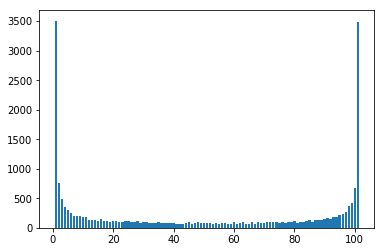

In [188]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# does prediction need to be a sorted array? How does that work for a data that has lat,lon?
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

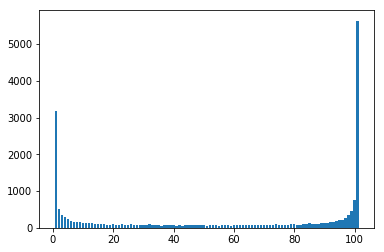

In [189]:
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show()

In [ ]:
print(obs_t850.shape)

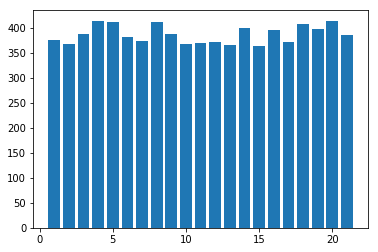

In [185]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

(10, 3)
(100, 10, 3)
(10, 3)


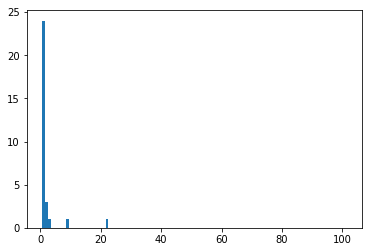

In [190]:
#testing for only few points. useless.
obs_small=obs_z500[:,15:18,0].squeeze()
pred_small=pred_z500[:,:,15:18,0]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #

(10, 32, 64)
(10, 10, 32, 64)
(10, 32, 64)


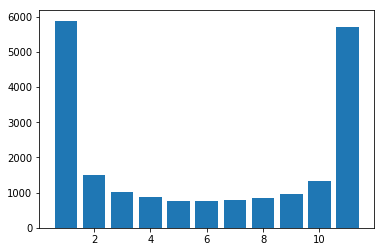

In [191]:
#testing for smaller number of bins (i.e. forecasts)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #overconfident (underdispersive)